<a href="https://colab.research.google.com/github/Bishara10/EEG-Classification/blob/main/EEG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Prerequisites


In [ ]:
!git clone https://github.com/BPy5/ML-Classification-model-For-EEG-Recordings.git

Cloning into 'ML-Classification-model-For-EEG-Recordings'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 313 (delta 27), reused 2 (delta 0), pack-reused 256
Receiving objects: 100% (313/313), 72.82 MiB | 18.36 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (247/247), done.


In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from scipy.signal import resample, spectrogram, butter, filtfilt
from scipy.stats import pearsonr

%matplotlib notebook
%matplotlib inline


# Preprocess dataset

### Load Data

In [ ]:
file_names_adhd_dataset = ['v8p.csv', 'v35p.csv', 'v37p.csv', 'v36p.csv', 'v38p.csv', 'v6p.csv', 'v40p.csv', 'v39p.csv', 'v3p.csv', 'v29p.csv', 'v30p.csv', 'v31p.csv', 'v28p.csv', 'v279.csv', 'v33p.csv', 'v25p.csv', 'v286.csv', 'v250.csv', 'v24p.csv', 'v246.csv', 'v263.csv', 'v27p.csv', 'v254.csv', 'v284.csv', 'v238.csv', 'v265.csv', 'v227.csv', 'v215.csv', 'v236.csv', 'v22p.csv', 'v21p.csv', 'v231.csv', 'v244.csv', 'v213.csv', 'v274.csv', 'v200.csv', 'v206.csv', 'v19p.csv', 'v173.csv', 'v270.csv', 'v234.csv', 'v179.csv', 'v181.csv', 'v18p.csv', 'v14p.csv', 'v196.csv', 'v209.csv', 'v183.csv', 'v12p.csv', 'v219.csv', 'v15p.csv', 'v20p.csv', 'v198.csv', 'v190.csv', 'v1p.csv', 'v32p.csv', 'v177.csv', 'v10p.csv', 'v34p.csv', 'v288.csv', 'v204.csv']
# print(len(file_names_adhd_dataset))
file_names_control_dataset = ['v51p.csv', 'v59p.csv', 'v304.csv', 'v45p.csv', 'v54p.csv', 'v58p.csv', 'v53p.csv', 'v60p.csv', 'v56p.csv', 'v46p.csv', 'v308.csv', 'v42p.csv', 'v43p.csv', 'v306.csv', 'v48p.csv', 'v50p.csv', 'v52p.csv', 'v302.csv', 'v44p.csv', 'v47p.csv', 'v307.csv', 'v57p.csv', 'v303.csv', 'v127.csv', 'v134.csv', 'v121.csv', 'v299.csv', 'v151.csv', 'v116.csv', 'v125.csv', 'v133.csv', 'v300.csv', 'v147.csv', 'v298.csv', 'v113.csv', 'v118.csv', 'v117.csv', 'v120.csv', 'v111.csv', 'v107.csv', 'v114.csv', 'v108.csv', 'v115.csv', 'v305.csv', 'v140.csv', 'v149.csv', 'v309.csv', 'v123.csv', 'v138.csv', 'v112.csv', 'v41p.csv', 'v129.csv', 'v143.csv', 'v310.csv', 'v131.csv', 'v297.csv', 'v109.csv', 'v49p.csv', 'v55p.csv', 'v110.csv']
# print(len(file_names_control_dataset))

pathControl = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/'
pathADHD = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/'
outputPath = '/content/preprocessed_dataset/'

### Functions for preprocessing
Downsampling: to redude the number of samples in the given data.
BandPassFilter to filter signal noise.
Preprocess_file: preprocesses a single file.
Preprocess_group: preprocess and save all files to a corresponding group folder.

In [ ]:
# Preprocessed dataset
dataADHD = []
dataControl = []

# parameters for bandpass filter
lowcut = 10.0
highcut = 40.0

# Set parameters for Spectrogram
original_fs = 128  # Sampling frequency in Hz
target_fs = 64  # Target sampling frequency in Hz
nperseg = 128  # Number of samples per segment
noverlap = 64  # Number of overlapping samples (typically half of nperseg)

In [ ]:
# filter channel and reduce noise.
def bandPassFilter(signal):
    fs = 4000.0

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 2
    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
    # print(f"Applying bandpass filter: lowcut={lowcut} Hz, highcut={highcut} Hz, fs={fs} Hz")
    # print(f"Normalized frequencies: low={low}, high={high}")
    y = scipy.signal.filtfilt(b, a, signal, axis=0)

    return y

In [ ]:
def pearson_correlation_two_signals(signal1, signal2):
  statistic, pvalue = pearsonr(signal1, signal2)

  return statistic, pvalue

In [ ]:
# # Function to pad spectrograms to a consistent length
# def pad_spectrogram(sxx, max_length):
#     if sxx.shape[1] < max_length:
#         padding = np.zeros((sxx.shape[0], max_length - sxx.shape[1]))
#         sxx = np.hstack((sxx, padding))
#     else:
#         sxx = sxx[:, :max_length]
#     return sxx

In [ ]:
# Function to downsample the signal
def downsample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    # print(f"Original signal length: {len(signal)}, Downsampled signal length: {num_samples}")
    return resample(signal, num_samples)

In [ ]:
# Preprocessing for an entire recording for a patient
def preprocess_file(input_file, group_category):
  df = pd.read_csv(input_file)
  new_signals = []
  pearson_cors = []

  for column in df.columns:
    signal = df[column].values
    downsampled_signal = downsample_signal(signal, original_fs, target_fs)
    filtered_signal = bandPassFilter(downsampled_signal)
    new_signals.append(filtered_signal)

  for signal in range(len(new_signals) - 1):
    for next_signal in range(len(new_signals)):
      corr, _ = pearson_correlation_two_signals(new_signals[signal], new_signals[next_signal])
      pearson_cors.append(corr)

  if group_category == 'ADHD':
    dataADHD.append(pearson_cors)
  elif group_category == 'CONTROL':
    dataControl.append(pearson_cors)

  # df.to_csv(output_file, index=False)

In [ ]:
# Preprocess all recordings for a specific group
def preprocess_group(group_path, group_file_names, output_path, group_category):
  i = 1
  for filename in group_file_names:
    file_name_and_path = group_path + filename;
    print(filename + ' data preprocessed ' + str(i) + '/' + str(len(group_file_names)))
    preprocess_file(file_name_and_path, group_category)
    i += 1
  print("=============================== Preprocessing group " + group_category + " successful =============================== ")

In [ ]:
# # Calculate the maximum time bins across all files
# def calculate_max_time_bins(files):
#     max_time_bins = 0
#     for file in files:
#         df = pd.read_csv(file)
#         for column in df.columns:
#             signal = df[column].values
#             downsampled_signal = downsample_signal(signal, original_fs, target_fs)
#             f, t, Sxx = spectrogram(downsampled_signal, fs=target_fs, nperseg=nperseg, noverlap=noverlap)
#             max_time_bins = max(max_time_bins, Sxx.shape[1])
#     return max_time_bins


In [ ]:
filesADHD = ['/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/' + x for x in file_names_adhd_dataset]
filesControl = ['/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/' + x for x in file_names_control_dataset]

# Find max time bin
# x = calculate_max_time_bins(filesADHD)
# y = calculate_max_time_bins(filesControl)
# maxTimeBins = max(x, y)


# preprocess groups
preprocess_group(pathADHD, file_names_adhd_dataset, outputPath + '/ADHD/', 'ADHD')
preprocess_group(pathControl, file_names_control_dataset, outputPath + '/Control/', 'CONTROL')


v8p.csv data preprocessed. 1/61
v35p.csv data preprocessed. 2/61
v37p.csv data preprocessed. 3/61
v36p.csv data preprocessed. 4/61
v38p.csv data preprocessed. 5/61
v6p.csv data preprocessed. 6/61
v40p.csv data preprocessed. 7/61
v39p.csv data preprocessed. 8/61
v3p.csv data preprocessed. 9/61
v29p.csv data preprocessed. 10/61
v30p.csv data preprocessed. 11/61
v31p.csv data preprocessed. 12/61
v28p.csv data preprocessed. 13/61
v279.csv data preprocessed. 14/61
v33p.csv data preprocessed. 15/61
v25p.csv data preprocessed. 16/61
v286.csv data preprocessed. 17/61
v250.csv data preprocessed. 18/61
v24p.csv data preprocessed. 19/61
v246.csv data preprocessed. 20/61
v263.csv data preprocessed. 21/61
v27p.csv data preprocessed. 22/61
v254.csv data preprocessed. 23/61
v284.csv data preprocessed. 24/61
v238.csv data preprocessed. 25/61
v265.csv data preprocessed. 26/61
v227.csv data preprocessed. 27/61
v215.csv data preprocessed. 28/61
v236.csv data preprocessed. 29/61
v22p.csv data preprocessed

In [ ]:
len(dataADHD)

61

In [ ]:
len(dataControl)

60

# ML Model: SVM

### Define classifier

### Prepare feature matrix and labels

In [ ]:
X = np.array(dataADHD + dataControl)
y = np.array([1] * len(dataADHD) + [0] * len(dataControl))

In [ ]:
X.shape

(121, 342)

# Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model


In [ ]:
svm = SVC(kernel='linear')


svm.fit(X_scaled, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [121, 96]

In [ ]:
svm.score(X_test, y_test)

0.6

# Plot results

In [ ]:
# Define the mesh grid parameters
h = .02  # Step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


ValueError: X has 2 features, but SVC is expecting 342 features as input.

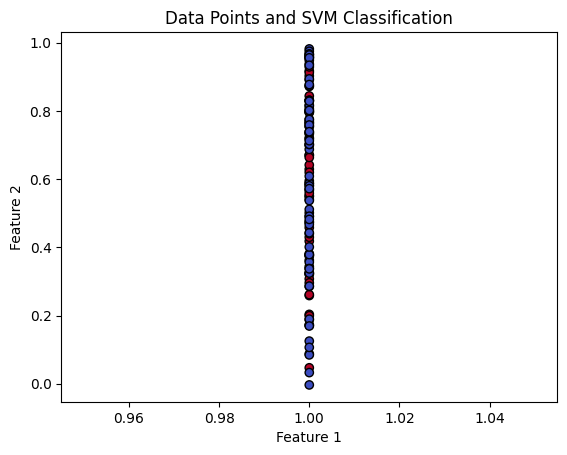

In [ ]:
# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Points and SVM Classification')

Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary with Data Points')
plt.show()

# Make a prediction

In [ ]:
# Evaluate the model
datax = np.expand_dims(dataControl[44], axis=0)
x = cnn.predict(datax)

print("ADHD") if x[0] > 0.5 else print("Control")


1/1 [==============================] - 0s 91ms/step
Control


# MISC


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
axes = axes.flatten()
df['2'].plot(kind='line', figsize=(8, 4), title='adhd', ax=axes[0])
df2['2'].plot(kind='line', figsize=(8, 4), title='control', ax=axes[1])
plt.gca().spines[['top', 'right']].set_visible(False)
# plt.xlim([0,3000])
plt.tight_layout()
plt.show()
